1. Build a Neural Machine Translation model.
2. Evaluate the model using BLEU score

In [1]:
pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import all dependentcies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import string
import unicodedata
from unidecode import unidecode
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras import optimizers

First we need to download dataset from provided link
Dataset: http://www.manythings.org/anki/fra-eng.zip

In [3]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2023-03-04 18:17:18--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7155035 (6.8M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   6.82M  30.5MB/s    in 0.2s    

2023-03-04 18:17:18 (30.5 MB/s) - ‘fra-eng.zip.1’ saved [7155035/7155035]



In [4]:
# check left hand side file fra-eng.zip, zip file has been downloaded
# now, we need to unzip this file
import zipfile
# copy dataset file path
zip_ref = zipfile.ZipFile("/content/fra-eng.zip", "r")
zip_ref.extractall('/content')
zip_ref.close()

##### after unzip, we have 2 text file, one is fra.txt and other is _about.txt,

In [5]:
# open fra.txt file
text = open("/content/fra.txt", "r", encoding = "utf-8").read()

In [6]:
#split a text into sentences
def to_sentences(text):
  # split text data into sentences
  sentences = text.strip().split('\n')
  # now, I am taking 75000 lines
  sen = [i.split('\t') for i in sentences[:100000]]
  return np.array(sen)

In [7]:
# call to_sentences function
eng_fra = to_sentences(text)
eng_fra.shape

(100000, 3)

In [8]:
eng_fra[:10]

array([['Go.', 'Va !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go.', 'Marche.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go.', 'En route !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)'],
       ['Go.', 'Bouge !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
       ['Hi.', 'Salut !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)'],
       ['Hi.', 'Salut.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)'],
       ['Run!', 'Cours\u202f!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)'],
       ['Run!', 'Courez\u202f!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)'],
       ['Run!', 'Prenez vos jambes

In [9]:
# in eng_fra text data, there are 3 columns, 1-> eng text, 2-> french text and 3-> discribtion
# we need to only first 2 columns
eng_fra = eng_fra[:, :2]
random.shuffle(eng_fra)
# split data into english_text and french_text
eng_text = eng_fra[:, 0]
fra_text = eng_fra[:, 1]

In [10]:
eng_text.shape, fra_text.shape # sentences length are not same

((100000,), (100000,))

## **Clean Data**
#### Remove the non printable charaters, if any
#### Remove punctuations and non-alphabetic charaters
#### Convert to lowercase

In [11]:
# demo, 
word = 'Prenez vos jambes à vos cous !'
decode_word = unidecode(word)
print(word, '--->', decode_word)

Prenez vos jambes à vos cous ! ---> Prenez vos jambes a vos cous !


In [12]:
def clean_data(sentences):
  data = []
  for word in sentences:
    # decode the word
    word = unidecode(word)
    # remove special characters and numbers
    word = re.sub('[^a-zA-z]', ' ', word)
    # remove extra spaces
    word = word.strip()
    # lower case
    word = word.lower()
    word = ''.join(w for w in unicodedata.normalize('NFKD', word))
    data.append(word)
  return np.array(data)

In [13]:
# clean french text and convert into list of word
fra_input = clean_data(fra_text)
# clean english text and convert into list of word
eng_target = clean_data(eng_text)

In [14]:
fra_input[:10]

array(['va', 'va', 'marche', 'bouge', 'en route', 'salut', 'cours',
       'bouge', 'cours', 'bouge'], dtype='<U66')

In [15]:
eng_target[:10]

array(['go', 'go', 'go', 'go', 'go', 'hi', 'run', 'go', 'run', 'go'],
      dtype='<U27')

### **Split Data into train and test**

In [16]:
x_train, x_test, y_train, y_test = train_test_split(fra_input, eng_target, test_size = 0.20, random_state = 42)

In [17]:
x_train.shape, y_train.shape

((80000,), (80000,))

In [18]:
x_test.shape, y_test.shape

((20000,), (20000,))

In [19]:
x_train[:10]

array(['c en est un gros', 'ne crie pas', 'avez vous deja dine',
       'paie moi un coup', 's il te plait  arrete', 'il est celibataire',
       'il s agissait d un secret', 'je t aimais',
       'ma femme a fondu en larmes', 'arrete de filmer'], dtype='<U66')

In [20]:
y_train[:10]

array(['it s a large one', 'don t shout', 'have you had dinner',
       'buy me a drink', 'please stop', 'he is unmarried',
       'it was a secret', 'i loved you', 'my wife burst into tears',
       'stop filming'], dtype='<U27')

## **Apply Tokenization**
#### convert words with their correcponding specific integers

In [21]:
def tokenization(text_data):
  # create tokenizer
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text_data)
  integer_sequence = tokenizer.texts_to_sequences(text_data)
  vocab = tokenizer.word_index
  vocab_size = len(vocab) + 1
  max_seq_len = max(len(seq) for seq in integer_sequence)

  return tokenizer, vocab, vocab_size, max_seq_len

In [22]:
# get tokenizer, vocabulary , vocabulary size and max_sequence_length
fra_tokenizer ,fra_vocab, fra_vocab_size, max_fra_seq_len = tokenization(fra_input)
print('french vocabulary size :', fra_vocab_size)
print('french max sequence length : ', max_fra_seq_len)

french vocabulary size : 10749
french max sequence length :  14


In [23]:
fra_vocab

{'je': 1,
 'est': 2,
 'a': 3,
 'vous': 4,
 'tom': 5,
 'pas': 6,
 'j': 7,
 'il': 8,
 'de': 9,
 'le': 10,
 'ai': 11,
 'ne': 12,
 'nous': 13,
 'tu': 14,
 'suis': 15,
 'la': 16,
 'c': 17,
 'un': 18,
 'en': 19,
 'l': 20,
 'ce': 21,
 'n': 22,
 'que': 23,
 'me': 24,
 'ca': 25,
 'une': 26,
 'les': 27,
 'etes': 28,
 'moi': 29,
 'd': 30,
 'es': 31,
 'y': 32,
 't': 33,
 'elle': 34,
 's': 35,
 'm': 36,
 'sont': 37,
 'tout': 38,
 'ils': 39,
 'etait': 40,
 'qui': 41,
 'fait': 42,
 'sommes': 43,
 'te': 44,
 'toi': 45,
 'as': 46,
 'mon': 47,
 'des': 48,
 'faire': 49,
 'elles': 50,
 'du': 51,
 'aime': 52,
 'ici': 53,
 'qu': 54,
 'avez': 55,
 'bien': 56,
 'peux': 57,
 'tres': 58,
 'se': 59,
 'cela': 60,
 'veux': 61,
 'ete': 62,
 'besoin': 63,
 'va': 64,
 'pour': 65,
 'avons': 66,
 'votre': 67,
 'on': 68,
 'etre': 69,
 'ont': 70,
 'comment': 71,
 'personne': 72,
 'ou': 73,
 'au': 74,
 'fais': 75,
 'aller': 76,
 'faut': 77,
 'air': 78,
 'plus': 79,
 'ton': 80,
 'dans': 81,
 'etais': 82,
 'ma': 83,
 'pourq

In [24]:
# get tokenizer, vocabulary , vocabulary size and max_sequence_length
eng_tokenizer ,eng_vocab, eng_vocab_size, max_eng_seq_len = tokenization(eng_target)
print('french vocabulary size :', fra_vocab_size)
print('french max sequence length : ', max_eng_seq_len)

french vocabulary size : 10749
french max sequence length :  8


In [25]:
eng_vocab

{'i': 1,
 'you': 2,
 'it': 3,
 'tom': 4,
 'a': 5,
 'is': 6,
 's': 7,
 't': 8,
 're': 9,
 'm': 10,
 'the': 11,
 'we': 12,
 'to': 13,
 'that': 14,
 'he': 15,
 'me': 16,
 'this': 17,
 'do': 18,
 'are': 19,
 'was': 20,
 'can': 21,
 'don': 22,
 'they': 23,
 'have': 24,
 'go': 25,
 'my': 26,
 'be': 27,
 'your': 28,
 'not': 29,
 'll': 30,
 'what': 31,
 'did': 32,
 'get': 33,
 'in': 34,
 'no': 35,
 'she': 36,
 'like': 37,
 'here': 38,
 'all': 39,
 'let': 40,
 'how': 41,
 'of': 42,
 'on': 43,
 'want': 44,
 'up': 45,
 'need': 46,
 'very': 47,
 'know': 48,
 'for': 49,
 'out': 50,
 'one': 51,
 'him': 52,
 'come': 53,
 'who': 54,
 'there': 55,
 'please': 56,
 'help': 57,
 'at': 58,
 'good': 59,
 'so': 60,
 'got': 61,
 'take': 62,
 've': 63,
 'love': 64,
 'just': 65,
 'see': 66,
 'us': 67,
 'now': 68,
 'too': 69,
 'look': 70,
 'stop': 71,
 'has': 72,
 'were': 73,
 'will': 74,
 'why': 75,
 'where': 76,
 'am': 77,
 'had': 78,
 'home': 79,
 'keep': 80,
 'must': 81,
 'back': 82,
 'stay': 83,
 'his': 84,

convert Train and test text data into integer sequence, and apply post padding

In [26]:
def integer_seq_with_padding(tokenizer, text, max_seq_len):
  # convert words into their correcponding integer
  integer_sequence = tokenizer.texts_to_sequences(text)
  # apply padding, adding zeros to same max_seq_length
  sequence_padded = pad_sequences(integer_sequence, maxlen = max_seq_len, padding = 'post')
  return sequence_padded

In [27]:
x_train_padded = integer_seq_with_padding(fra_tokenizer ,x_train, max_fra_seq_len)
y_train_padded = integer_seq_with_padding(eng_tokenizer ,y_train, max_eng_seq_len)

In [28]:
x_train_padded.shape, y_train_padded.shape

((80000, 14), (80000, 8))

In [29]:
x_test_padded = integer_seq_with_padding(fra_tokenizer ,x_test, max_fra_seq_len)
y_test_padded = integer_seq_with_padding(eng_tokenizer ,y_test, max_eng_seq_len)

In [30]:
x_test_padded.shape, y_test_padded.shape

((20000, 14), (20000, 8))

## **Encoder Decoder Sequential Model**

In [31]:
def create_model(input_vocab_size, output_vocab_size, input_timesteps, output_timesteps, units):
    model = Sequential()
    model.add(Embedding(input_vocab_size, units, input_length = input_timesteps, mask_zero=True))
    model.add(LSTM(units, dropout = 0.3))
    model.add(RepeatVector(output_timesteps))
    model.add(LSTM(units, return_sequences=True, dropout = 0.3))
    model.add(TimeDistributed(Dense(output_vocab_size, activation='softmax')))
    return model

In [32]:
model = create_model(fra_vocab_size, eng_vocab_size, max_fra_seq_len, max_eng_seq_len, 1024)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 1024)          11006976  
                                                                 
 lstm (LSTM)                 (None, 1024)              8392704   
                                                                 
 repeat_vector (RepeatVector  (None, 8, 1024)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 1024)           8392704   
                                                                 
 time_distributed (TimeDistr  (None, 8, 6462)          6623550   
 ibuted)                                                         
                                                                 
Total params: 34,415,934
Trainable params: 34,415,934
No

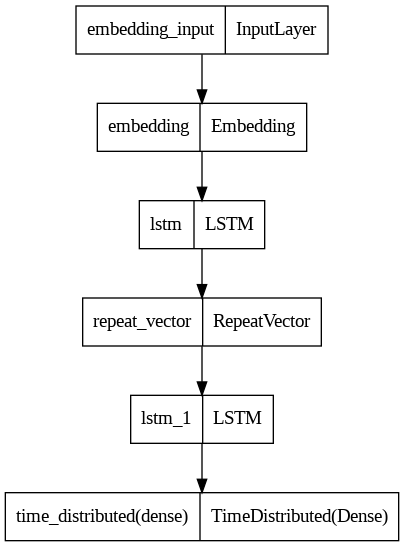

In [34]:
plot_model(model)

In [35]:
es = EarlyStopping(monitor = 'val_accuracy',patience = 5, min_delta = 0.01)

In [36]:
history = model.fit(x_train_padded, y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1],1),
          epochs = 30,
          batch_size = 1024,
          validation_data = (x_test_padded, y_test_padded.reshape(y_test_padded.shape[0], y_test_padded.shape[1],1)),
          verbose = 1, callbacks = [es])

Epoch 1/30
79/79 [==============================] - 47s 452ms/step - loss: 3.1744 - accuracy: 0.5550 - val_loss: 2.6874 - val_accuracy: 0.5741
Epoch 2/30
79/79 [==============================] - 31s 397ms/step - loss: 2.4828 - accuracy: 0.6039 - val_loss: 2.3360 - val_accuracy: 0.6190
Epoch 3/30
79/79 [==============================] - 31s 395ms/step - loss: 2.1487 - accuracy: 0.6470 - val_loss: 2.0627 - val_accuracy: 0.6624
Epoch 4/30
79/79 [==============================] - 31s 398ms/step - loss: 1.8636 - accuracy: 0.6814 - val_loss: 1.7861 - val_accuracy: 0.6893
Epoch 5/30
79/79 [==============================] - 34s 430ms/step - loss: 1.6288 - accuracy: 0.7063 - val_loss: 1.6285 - val_accuracy: 0.7077
Epoch 6/30
79/79 [==============================] - 31s 396ms/step - loss: 1.4235 - accuracy: 0.7304 - val_loss: 1.4387 - val_accuracy: 0.7323
Epoch 7/30
79/79 [==============================] - 31s 398ms/step - loss: 1.2373 - accuracy: 0.7548 - val_loss: 1.2917 - val_accuracy: 0.7529

Save Model

In [37]:
model_name = 'NMT_model.h5'
model.save(model_name)

## plot model train and test accuracy and loss

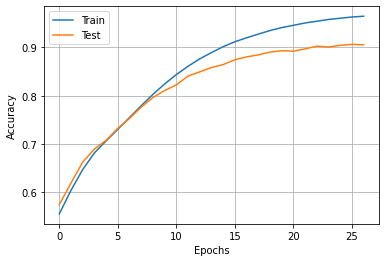

In [38]:
train_data_acc = history.history['accuracy']
test_data_acc = history.history['val_accuracy']
plt.plot(train_data_acc)
plt.plot(test_data_acc)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

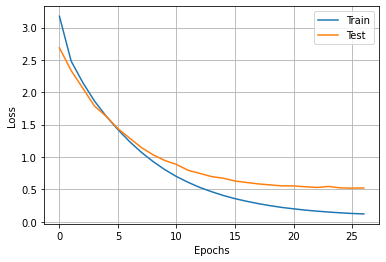

In [39]:
train_data_loss = history.history['loss']
test_data_loss = history.history['val_loss']
plt.plot(train_data_loss)
plt.plot(test_data_loss)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

## Predict Test data

In [40]:
# check text data shape
x_test_padded.shape

(20000, 14)

In [41]:
#NMT_model = load_model('/content/NMT_model.h5')

In [42]:
# predict test data
predicted = model.predict(x_test_padded)

625/625 [==============================] - 7s 8ms/step


In [43]:
# predicted shape
predicted.shape

(20000, 8, 6462)

In [44]:
# now, we need to decode predicted data into english integer sequence
preds = []
for seq in predicted:
  temp = []
  for j in seq:
    temp.append(np.argmax(j))
  # remove padding
  temp = [w for w in temp if w != 0]
  preds.append(temp)

In [45]:
preds

[[206, 21, 2, 282],
 [1, 426, 8, 18, 14, 146],
 [1, 44, 14, 126],
 [1, 120, 1798],
 [6, 3, 95, 2],
 [4, 6, 391],
 [21, 2, 348, 38],
 [40, 7, 252, 43],
 [1, 10, 5, 300, 229],
 [15, 6, 5, 59, 310],
 [14, 407, 225],
 [1, 21, 8, 252, 26, 993],
 [65, 122, 619],
 [23, 30, 27, 281],
 [12, 37, 4],
 [11, 1460, 6, 561],
 [138],
 [33, 13, 175],
 [36, 319, 34, 5, 903],
 [23, 25, 956],
 [116, 49, 5, 654, 3307],
 [447, 52],
 [1, 37, 723, 2119],
 [7],
 [1, 48, 14],
 [1, 219, 187],
 [55, 19, 35, 517, 5132],
 [4, 6, 1951],
 [3, 7, 29, 394, 59],
 [2, 144, 52],
 [21, 8, 12, 65, 25],
 [1, 516, 115],
 [14, 7, 16],
 [2, 9, 29, 37, 16],
 [15, 20, 401],
 [71, 303, 685],
 [2, 21, 8, 102, 45],
 [1, 24, 39, 39, 18],
 [367, 19, 19],
 [1, 37, 26, 126],
 [4, 186, 14],
 [1, 85, 4, 74, 127, 2],
 [212, 14, 34, 611],
 [90, 17, 13, 16],
 [14, 7, 95, 849],
 [130, 171, 19, 563],
 [1, 46, 4493],
 [15, 32, 3],
 [6, 4, 163],
 [1, 30, 25],
 [38, 6, 11, 904],
 [195, 1430],
 [1, 98, 8, 2250],
 [22, 8, 114, 1469],
 [127, 67, 31,

In [46]:
# convert predicted integer sequences into their corresponding word
predict_text = eng_tokenizer.sequences_to_texts(preds)

In [47]:
predict_text

['when can you start',
 'i couldn t do that today',
 'i want that job',
 'i hate violence',
 'is it really you',
 'tom is trying',
 'can you sign here',
 'let s move on',
 'i m a little early',
 'he is a good boy',
 'that sounds great',
 'i can t move my leg',
 'just say yes',
 'they ll be fine',
 'we like tom',
 'the rent is empty',
 'run',
 'get to bed',
 'she works in a bank',
 'they go shopping',
 'wait for a few seconds',
 'grab him',
 'i like playing sports',
 's',
 'i know that',
 'i found these',
 'there are no broken bones',
 'tom is clueless',
 'it s not looking good',
 'you hurt him',
 'can t we just go',
 'i slept well',
 'that s me',
 'you re not like me',
 'he was naive',
 'stop being cruel',
 'you can t give up',
 'i have all all do',
 'those are are',
 'i like my job',
 'tom likes that',
 'i think tom will tell you',
 'put that in writing',
 'leave this to me',
 'that s really low',
 'some more are beautiful',
 'i need protection',
 'he did it',
 'is tom ok',
 'i ll go'

In [48]:
y_test

array(['when can you start', 'i couldn t do that today',
       'i want that job', ..., 'you re very wise', 'go warm up',
       'take it or leave it'], dtype='<U27')

In [49]:
df = pd.DataFrame({'Text': y_test, 'Predicted':predict_text})

In [50]:
df

,Text,Predicted
0,when can you start,when can you start
1,i couldn t do that today,i couldn t do that today
2,i want that job,i want that job
3,i hate violence,i hate violence
4,is it really you,is it really you
...,...,...
19995,tom taught french,tom taught french
19996,were you shot at,were you shot at
19997,you re very wise,you re very wise
19998,go warm up,go warm up


Use BLEU score for evaluating model using NLTK library

In [51]:
from nltk.translate.bleu_score import sentence_bleu

In [52]:
Sum = 0
for i in range(len(df)):
  reference = [df['Text'][i].split()]
  candidate = df['Predicted'][i].split()
  score = sentence_bleu(reference, candidate, weights = (1.0, 0, 0, 0))
  Sum += score

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [53]:
print("The average Bleu Score is {:.2f} %".format(Sum*100/len(df)))

The average Bleu Score is 83.33 %


In [54]:
df_same = df[df['Text'] == df['Predicted']]
df_same

,Text,Predicted
0,when can you start,when can you start
1,i couldn t do that today,i couldn t do that today
2,i want that job,i want that job
3,i hate violence,i hate violence
4,is it really you,is it really you
...,...,...
19995,tom taught french,tom taught french
19996,were you shot at,were you shot at
19997,you re very wise,you re very wise
19998,go warm up,go warm up
